<a href="https://colab.research.google.com/github/notsrujangupta/Start_Hack_SBB_Project_Parkalot/blob/main/hardware_location_identification_kmeans.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import pandas as pd
import numpy as np
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.datasets.samples_generator import make_blobs
from sklearn.cluster import KMeans
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_samples,silhouette_score



In [4]:
df2 = pd.read_csv('passagierfrequenz.csv', sep =';')



df = df2[["DTV","DWV","DNWV", 'Bahnhof_Haltestelle']].copy()
df= df.dropna(how='any', axis=0)


print (df.head)
print(df2.columns)

def truncate(n):
  return int(n * 100000000) / 100000000


<bound method NDFrame.head of          DTV      DWV     DNWV Bahnhof_Haltestelle
0     1700.0   2000.0   1000.0              Aadorf
1    37900.0  44800.0  22700.0               Aarau
2     2500.0   3000.0   1300.0   Aarburg-Oftringen
3      740.0    800.0    610.0              Aathal
4       90.0     90.0     80.0    Acla da Fontauna
..       ...      ...      ...                 ...
901  11600.0  13800.0   6500.0     Zürich Wiedikon
902   2400.0   2700.0   1700.0    Zürich Wipkingen
903   3400.0   3800.0   2600.0  Zürich Wollishofen
904    100.0    110.0     70.0            Zweidlen
905   2500.0   2900.0   1500.0             Zwingen

[902 rows x 4 columns]>
Index(['Code', 'Bahnhof_Haltestelle', 'Bezugsjahr', 'Kanton', 'Eigner', 'DTV',
       'DWV', 'DNWV', 'Bemerkungen', 'Remarques', 'Note', 'Remarks', 'geopos',
       'lod'],
      dtype='object')


Identifying Zscores for weekly, weekday and weekend traffic for each location.

Goal is to check which locations are farthest and closest to the mean with standardd deviations. This will help identify a range of locations that fall within every type of traffic.

In [5]:
#DTV
dtv = df['DTV'].to_numpy()
dtv = np.log(dtv)
dtv = dtv.reshape(-1,1)

scaler = StandardScaler()
scaler.fit(dtv)
dtv_SC = scaler.transform(dtv)
dtv_SC = dtv_SC.flatten()

dtv_SC = pd.Series(dtv_SC)

for i in range(len(dtv_SC)):
  dtv_SC[i]= truncate(dtv_SC[i])
  
df = df.assign(dtv_SC=dtv_SC)

In [6]:


#DWV
del scaler
dwv=df['DWV'].to_numpy()
dwv=np.log(dwv)
dwv =dwv.reshape(-1,1)

scaler = StandardScaler()
scaler.fit(dwv)
dwv_SC = scaler.transform(dwv)
dwv_SC = dwv_SC.flatten()

dwv_SC = pd.Series(dwv_SC)

for i in range(len(dwv_SC)):
  dwv_SC[i]= truncate(dwv_SC[i])
df = df.assign(dwv_SC=dwv_SC)


In [7]:

#DNWV
del scaler
dnwv=df['DNWV'].to_numpy()
dnwv=np.log(dnwv)
dnwv = dnwv.reshape(-1,1)

scaler= StandardScaler()
scaler.fit(dnwv)
dnwv_SC = scaler.transform(dnwv)
dnwv_SC = dnwv_SC.flatten()

dnwv_SC = pd.Series(dnwv_SC)

for i in range(len(dnwv_SC)):
  dnwv_SC[i]= truncate(dnwv_SC[i])
df = df.assign(dnwv_SC=dnwv_SC)




df= df.dropna(how='any', axis=0)
print(np.where(pd.isnull(df)))




dtv_stats = df['DTV'].describe()
dwv_stats = df['DWV'].describe()
dnwv_stats = df['DNWV'].describe()

#print(dtv_stats.loc['mean'])

#print(df.skew())

(array([], dtype=int64), array([], dtype=int64))


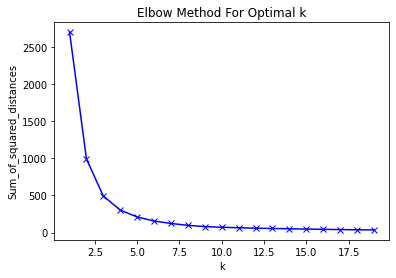

In [12]:
np.random.seed(42)

Sum_of_squared_distances = []
K = range(1,20)
for k in K:
    kmeans = KMeans(n_clusters=k)
    y = kmeans.fit(df[['dtv_SC', 'dwv_SC', 'dnwv_SC']])
    Sum_of_squared_distances.append(y.inertia_)

plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

[ 0.24402513 26.5204592   6.33564807 41.96764778 15.51592991]
0
0.2440251267269815
       DTV      DWV     DNWV  ...   dnwv_SC  Cluster  Dist_To_Cluster_Centroid
0   1700.0   2000.0   1000.0  ...  0.436398        4                  0.339490
1  37900.0  44800.0  22700.0  ...  2.431423        0                  0.244025
2   2500.0   3000.0   1300.0  ...  0.604035        2                  0.233670
3    740.0    800.0    610.0  ...  0.120570        4                  0.069519
4     90.0     90.0     80.0  ... -1.177407        3                  0.005174

[5 rows x 9 columns]


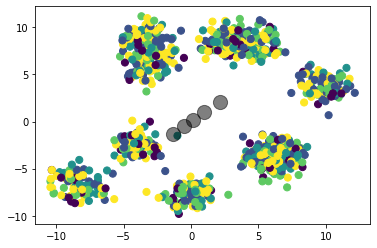

In [37]:
X, _ = make_blobs(n_samples=len(df), centers=10, n_features=3)

num_clusters = 5
km = KMeans(n_clusters=num_clusters)

##Getting the cluster for each point
y = km.fit_predict(df[['dtv_SC', 'dwv_SC', 'dnwv_SC']])

##getting the sqaured distance of each point to each centroid
X_dist = km.transform(df[['dtv_SC', 'dwv_SC', 'dnwv_SC']])**2 

##getting coordinates of each centroid
centroids = km.cluster_centers_ 

df['Cluster'] = y

dist_to_cluster_centroid = []

for i in range(len(X_dist)):
  dist_to_cluster_centroid.append(min(X_dist[i]))

df['Dist_To_Cluster_Centroid'] = dist_to_cluster_centroid

plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='viridis')

centers = km.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5);

print(X_dist[1])
print(df['Cluster'][1])
print(df['Dist_To_Cluster_Centroid'][1])
print(df.head())

Finding the closest point to each Centroid

In [72]:
num_of_closest_points = round(50/num_clusters)
closest_points=[]
for i in range(num_clusters):
  temp_df = df[df['Cluster']==i]
  temp_df = temp_df.sort_values('Dist_To_Cluster_Centroid', axis= 0, ascending = True)



  ##print(temp_df[0: num_of_closest_points])
  closest_points.append(temp_df[0: num_of_closest_points])


    
for s in range(len(closest_points)):
  n=closest_points[s]['Bahnhof_Haltestelle']
  print(n)


  


434              Lengwil
809          Unterterzen
848              Wattwil
533              Nebikon
821             Vernayaz
606      Rämismühle-Zell
275    Fribourg/Freiburg
765          Steinerberg
208             Dietikon
108             Brugg AG
Name: Bahnhof_Haltestelle, dtype: object
854    Wiesendangen
637           Rivaz
58           Benken
791            Thun
799            Trun
610           Raron
520      Münster VS
497            Mies
161       Colombier
795         Travers
Name: Bahnhof_Haltestelle, dtype: object
274    Frenkendorf-Füllinsdorf
268                     Flawil
296                Glanzenberg
499                    Mitlödi
235         Emmenbrücke Gersag
337            Herzogenbuchsee
328                  Heerbrugg
336      Herrliberg-Feldmeilen
899         Zürich Stadelhofen
511                      Mosen
Name: Bahnhof_Haltestelle, dtype: object
636          Ringgenberg
423                Lavin
4       Acla da Fontauna
500           Mogelsberg
102          Brie